# Python intro

gdsfactory is written in python and requires some basic knowledge of python.

If you are new to python you can find many resources online

- [books](https://jakevdp.github.io/PythonDataScienceHandbook/index.html)
- [youTube videos](https://www.youtube.com/c/anthonywritescode)
- [courses](https://github.com/joamatab/practical-python)

This notebook is for you to experiment with some common python patterns in `gdsfactory`

## Classes

Gdsfactory has already some pre-defined classes for you.

All the other classes (Component, ComponentReference, Port ...) are already available in `gf.typings`

Classes are good for keeping state, which means that they store some information inside them (polygons, ports, references ...).

In gdsfactory you will write functions instead of classes. Functions are easier to write and combine, and have clearly defined inputs and outputs.

In [1]:
from functools import partial
from pydantic import validate_call
import gdsfactory as gf

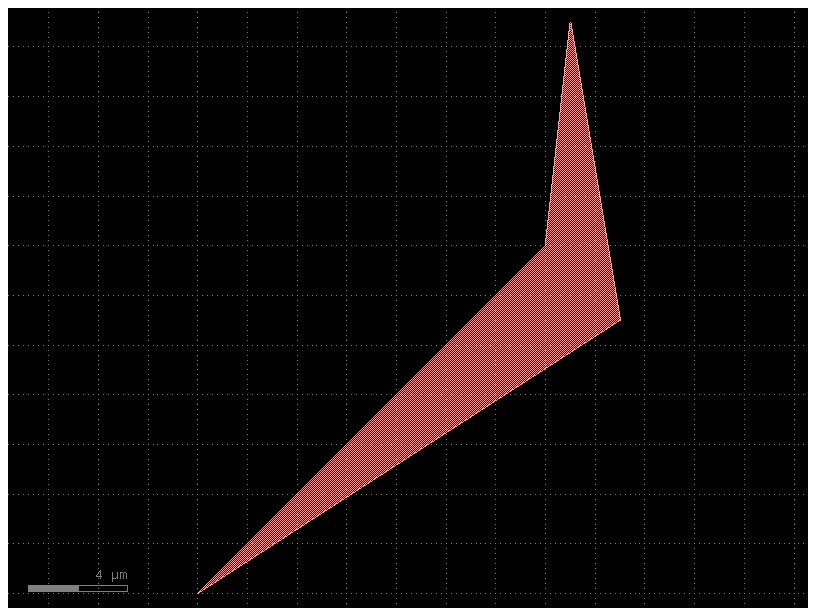

In [2]:
c = gf.Component()
c.add_polygon([(-8, -6), (6, 8), (7, 17), (9, 5)], layer=(1, 0))
c.plot()

## Functions

Functions have clear inputs and outputs, they usually accept some parameters (strings, floats, ints ...) and return other parameters


In [3]:
def double(x):
    return 2 * x


x = 1.5
y = double(x)
print(y)

3.0


It's also nice to add `type annotations` to your functions to clearly define what are the input/output types (string, int, float ...)


In [4]:
def double(x: float) -> float:
    return 2 * x

## Factories

A factory is a function that returns an object. In gdsfactory many functions return a `Component` object


bend_euler_R10_A90_P0p5_2f1f5c6d: ports ['o1', 'o2'], 0 instances


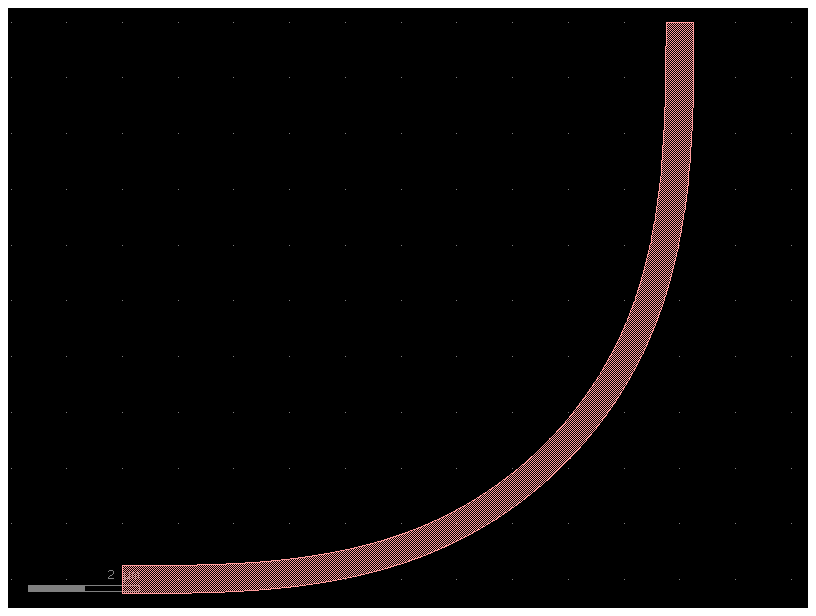

In [5]:
def bend(radius: float = 5) -> gf.typings.Component:
    return gf.components.bend_euler(radius=radius)


component = bend(radius=10)

print(component)
component.plot()

## Decorators

gdsfactory has many functions, and we want to do some common operations for the ones that return a Component:

- give a unique name (dependent on the input parameters) to a Component
- validate input arguments based on type annotations
- cache the Component that the function returns for speed and reuse cells.

For that you will see a `@cell` decorator on many component functions.

The validation functionality comes from the [pydantic](https://pydantic-docs.helpmanual.io/) package
and is available to you automatically when using the `@cell` decorator


In [ ]:
@validate_call
def double(x: float) -> float:
    return 2 * x


x = 1.5
y = double(x)
print(y)

The validator decorator is equivalent to running


In [ ]:
def double(x: float) -> float:
    return 2 * x


double_with_validator = validate_call(double)
x = 1.5
y = double_with_validator(x)
print(y)

The `cell` decorator also leverages that validate arguments.
So you should add type annotations to your component factories.

Lets try to create an error `x` and you will get a clear message the the function `double` does not work with strings

```python
y = double("not_valid_number")
```

will raise a `ValidationError`

```
ValidationError: 0 validation error for Double
x
  value is not a valid float (type=type_error.float)

```

It will also `cast` the input type based on the type annotation. So if you pass an `int` it will convert it to `float`

In [ ]:
x = 1
y = double_with_validator(x)
print(y, type(x), type(y))

## List comprehensions

You will also see some list comprehensions, which are common in python.

For example, you can write many loops in one line

In [ ]:
y = []
for x in range(3):
    y.append(double(x))

print(y)

In [ ]:
y = [double(x) for x in range(3)]  # much shorter and easier to read
print(y)

## Functional programming

Functional programming follows linux philosophy:

- Write functions that do one thing and do it well.
- Write functions to work together.
- Write functions with clear **inputs** and **outputs**

### partial

Partial is an easy way to modify the default arguments of a function. This is useful in gdsfactory because we define PCells using functions. `from functools import partial`

You can use partial to create a new function with some default arguments.

The following two functions are equivalent in functionality. Notice how the second one is shorter, more readable and easier to maintain thanks to `partial`:


In [6]:
def ring_sc(gap=0.3, **kwargs) -> gf.Component:
    return gf.components.ring_single(gap=gap, **kwargs)


ring_sc = partial(gf.components.ring_single, gap=0.3)  # shorter and easier to read

As you customize more parameters, it's more obvious that the second one is easier to maintain


In [7]:
def ring_sc(gap=0.3, radius=10, **kwargs):
    return gf.components.ring_single(gap=gap, radius=radius, **kwargs)


ring_sc = partial(gf.components.ring_single, gap=0.3, radius=10)

### compose

`gf.compose` combines two functions into one. This is useful in gdsfactory because we define PCells using functions and functions are easier to combine than classes. You can also import compose from the toolz package `from toolz import compose`

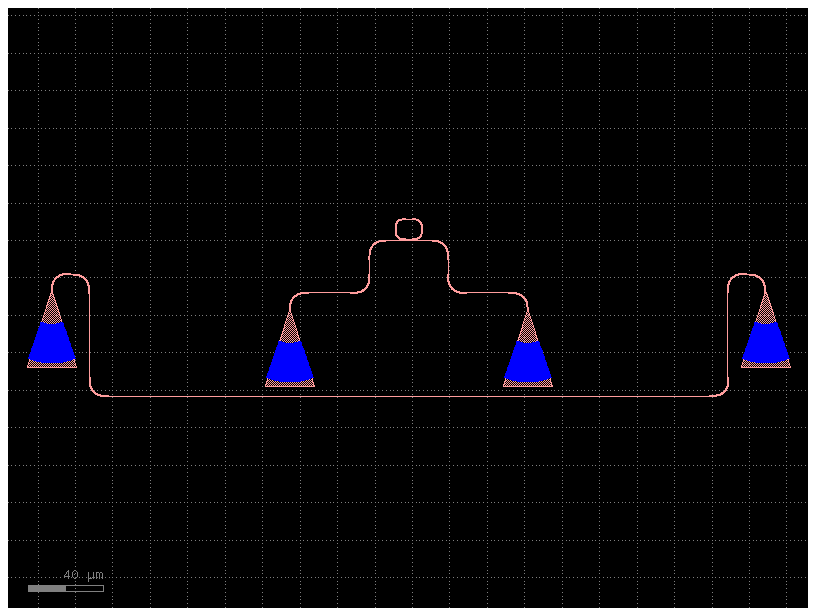

In [8]:
ring_sc = partial(gf.components.ring_single, radius=10)
add_gratings = gf.routing.add_fiber_array

ring_sc_gc = gf.compose(add_gratings, ring_sc)
ring_sc_gc5 = ring_sc_gc(radius=5)
ring_sc_gc5

In [ ]:
ring_sc_gc20 = ring_sc_gc(radius=20)
ring_sc_gc20

This is equivalent and more readable than writing

In [ ]:
ring_sc_gc5 = add_gratings(ring_sc(radius=5))
ring_sc_gc5

In [ ]:
ring_sc_gc20 = add_gratings(ring_sc(radius=20))
ring_sc_gc20

In [ ]:
print(ring_sc_gc5)

## Ipython

This Jupyter Notebook uses an Interactive Python Terminal (Ipython). So you can interact with the code.

For more details on Jupyter Notebooks, you can visit the [Jupyter website](https://jupyter.org/).

The most common trick that you will see is that we use `?` to see the documentation of a function or `help(function)`

In [ ]:
gf.components.coupler?

In [ ]:
help(gf.components.coupler)

To see the source code of a function you can use `??`

In [ ]:
gf.components.coupler??

To time the execution time of a cell, you can add a `%time` on top of the cell

In [ ]:
%time


def hi() -> None:
    print("hi")


hi()

For more Ipython tricks you can find many resources available online

## gdsfactory downloads

You can also use python plot the downloads for gdsfactory over the last year.

In [ ]:
import datetime

import plotly.graph_objects as go
import requests

downloads0 = 0


def get_total_downloads(package_name):
    statistics = []
    end_date = datetime.date.today()

    while True:
        url = f"https://pypistats.org/api/packages/{package_name}/overall"
        response = requests.get(url, params={"last_day": end_date})
        data = response.json()

        if response.status_code != 200:
            return None

        statistics.extend(
            [(entry["date"], entry["downloads"]) for entry in data["data"]]
        )
        if "next_day" in data:
            end_date = data["next_day"]
        else:
            break
    statistics.sort(key=lambda x: x[0])  # Sort by date
    dates, downloads = zip(*statistics)
    cumulative_downloads = [
        sum(downloads[: i + 1]) + downloads0 for i in range(len(downloads))
    ]

    return dates, cumulative_downloads


# Replace 'gdsfactory' with the package you want to check
package_name = "gdsfactory"
dates, cumulative_downloads = get_total_downloads(package_name)

if dates and cumulative_downloads:
    fig = go.Figure(data=go.Scatter(x=dates, y=cumulative_downloads))
    fig.update_layout(
        xaxis=dict(title="Date", tickformat="%Y-%m-%d", tickangle=45, showgrid=True),
        yaxis=dict(title="Total Downloads", showgrid=True),
        title=f"Total Downloads - {package_name}",
    )
    fig.update_layout(autosize=False, width=800, height=600)
    fig.show()
else:
    print(f"Failed to retrieve download statistics for package '{package_name}'.")